# Basic characterizations of LA Q3
### using Experiment and Analysis classes

In [1]:
from qm.qua import *
from qm import QuantumMachinesManager, SimulationConfig, LoopbackInterface, generate_qua_script
from qm.octave import *
from qm.octave.octave_manager import ClockMode
from configuration import *
from scipy import signal
from qualang_tools.bakery import baking
from qualang_tools.units import unit
from qm.octave import QmOctaveConfig
from set_octave import ElementsSettings, octave_settings
from quam import QuAM
from scipy.io import savemat, loadmat
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from qutip import *
from typing import Union
from macros import *
import datetime 
import os
import time
import warnings
import json
import matplotlib.pyplot as plt
import numpy as np
import Labber

from ExperimentClass import ExperimentHandle
from AnalysisClass import AnalysisHandle

warnings.filterwarnings("ignore")

qubit_index = 6 # for LA Q3
res_index = 6 # for LA Q3
flux_index = 6 # for LA Q3
TLS_index = 0 # for TLS of interest

2024-01-04 09:05:25,141 - qm - INFO     - Starting session: e883d132-9b37-4352-9def-b151601a8a6c


In [2]:
Experiment = ExperimentHandle()
Analysis = AnalysisHandle()
machine = Analysis.get_machine()

In [3]:
# initialize Labber-controlled hardware
Experiment.set_Labber(Analysis.get_machine(), qubit_index, res_index, flux_index)
# set octave to external clock
#Experiment.set_external_clock()

In [4]:
machine.qubits[qubit_index].lo = machine.qubits[qubit_index].f_01 + 50e6
machine = Analysis.set_machine(machine)

In [ ]:
# this updates the octave settings, including rf_gain and rf_output_mode
Experiment.octave_calibration(qubit_index,res_index,flux_index,calibration_flag = False)

In [5]:
# octave calibration
Experiment.octave_calibration(qubit_index,res_index,flux_index,calibration_flag = True)

2024-01-04 09:05:56,156 - qm - INFO     - Octave "octave1" Health check passed, current temperature 57


INFO:qm:Octave "octave1" Health check passed, current temperature 57


2024-01-04 09:05:56,159 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-01-04 09:05:56,176 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r6 for (LO, IF) = (6.068 GHz, -50.000 MHz)
2024-01-04 09:06:03,629 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q6 for (LO, IF) = (5.492 GHz, -50.000 MHz)
2024-01-04 09:06:15,674 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


## Time of flight

DC offset to add to I: -0.010390 V
DC offset to add to Q: -0.011469 V
TOF to add: 0.0 ns


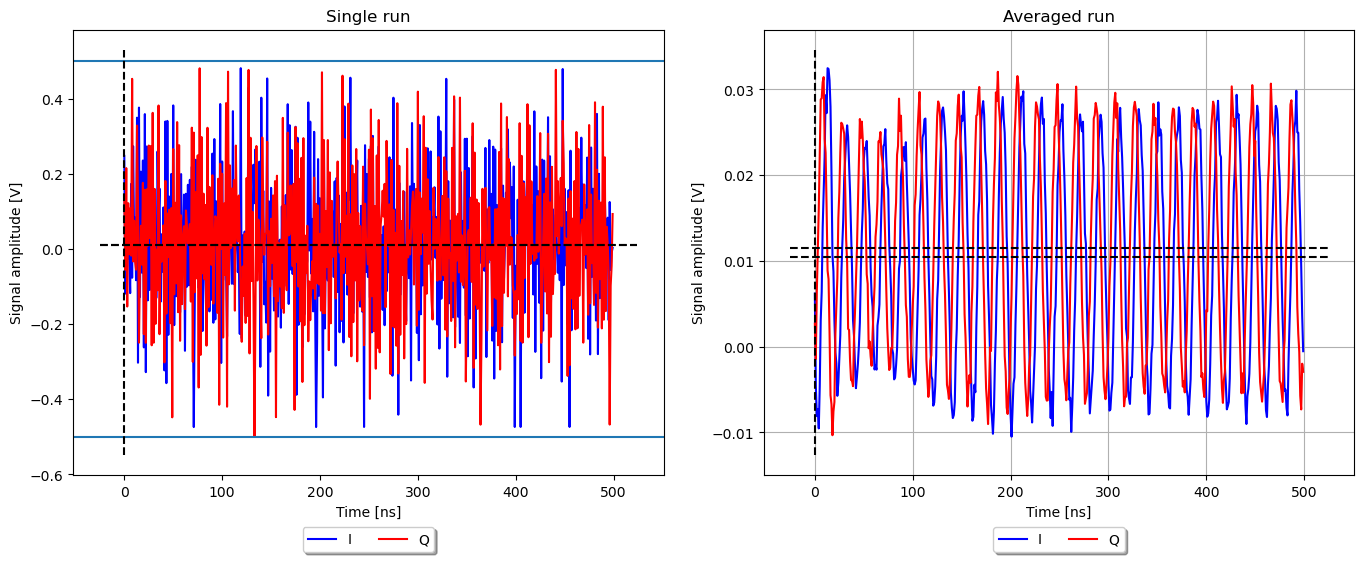

In [6]:
# time_of_flight
# experiment
machine, adc1, adc2, adc1_single, adc2_single = Experiment.exp1D.RR.time_of_flight(qubit_index,res_index,flux_index, n_avg = 10E3, cd_time = 10E3, simulate_flag = False, simulation_len = 1000)
# plot
%matplotlib inline
dc_offset_i, dc_offset_q, delay = Analysis.exp1D.time_of_flight(adc1,adc2,adc1_single,adc2_single)

In [7]:
# update the offset
machine.global_parameters.con1_downconversion_offset_I += dc_offset_i.item()
machine.global_parameters.con1_downconversion_offset_Q += dc_offset_q.item()
#machine.global_parameters.time_of_flight = 304-0
machine = Analysis.set_machine(machine)

## 1D RO resonator spectroscopy

In [105]:
%matplotlib qt
machine = Analysis.get_machine()
res_freq_sweep = machine.resonators[res_index].f_readout + np.arange(-10E6,10E6 + 1.0,0.05E6)
machine, res_freq_sweep, sig_amp = Experiment.exp1D.RR.rr_freq(res_freq_sweep, qubit_index, res_index, flux_index, 
                            n_avg = 1E3, cd_time = 5E3, readout_state = 'g', simulate_flag = False, simulation_len = 1000)
# Readout in excited state
# machine, res_freq_sweep, sig_amp = Experiment.exp1D.RR.rr_freq(res_freq_sweep, qubit_index, res_index, flux_index, 
#                           n_avg = 1E3, cd_time = 5E3, readout_state = 'e', simulate_flag = False, simulation_len = 1000)

Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 2.22s
Execution stopped by user!


resonator frequency: 6021.287 MHz


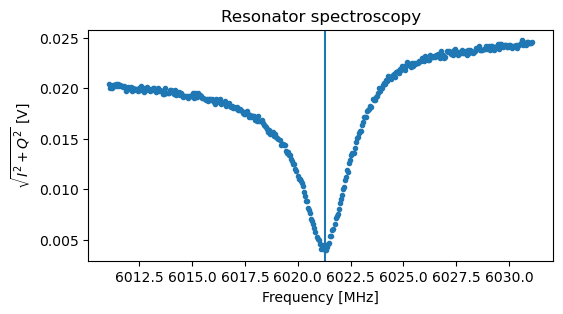

In [106]:
# find the minimal
%matplotlib inline
res_freq = Analysis.exp1D.rr_freq(res_freq_sweep, sig_amp)
machine.resonators[res_index].f_readout = res_freq.tolist() + 0E6
machine.resonators[res_index].lo = res_freq.tolist() + 50E6
machine = Analysis.set_machine(machine)

In [10]:
# octave calibration
Experiment.octave_calibration(qubit_index,res_index,flux_index,calibration_flag = True)

2024-01-04 09:08:00,263 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-01-04 09:08:00,274 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r6 for (LO, IF) = (6.071 GHz, -50.000 MHz)
2024-01-04 09:08:06,931 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q6 for (LO, IF) = (5.492 GHz, -50.000 MHz)
2024-01-04 09:08:19,524 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


In [13]:
machine.resonators[res_index].f_readout

6021200000.0

## 2D RO resonator spectroscopy vs DC flux

In [23]:
res_freq_sweep = np.arange(6.01E9,6.025E9 + 1.0,0.1E6)
dc_flux_sweep = np.arange(-9,9.001,0.5)
%matplotlib qt
machine, res_freq_sweep, dc_flux_sweep, sig_amp = Experiment.exp2D.RR.rr_vs_dc_flux(res_freq_sweep, dc_flux_sweep, qubit_index, res_index, flux_index, 
                            n_avg = 1E3, cd_time = 10E3)

Progress: [##################################################] 100.0% (n=37/37)
Execution stopped by user!


In [30]:
%matplotlib qt
ham_param = Analysis.exp2D.rr_vs_dc_flux(res_freq_sweep, dc_flux_sweep, sig_amp, init_guess = [6121, 160, 30E3, 0.05, 0.4, 70])
poly_param = Analysis.exp2D.qubit_vs_dc_flux_guess(ham_param)

In [31]:
# save the fitting parameters
machine.resonators[res_index].tuning_curve = ham_param.tolist()
machine.qubits[qubit_index].DC_tuning_curve = poly_param.tolist()
machine = Analysis.set_machine(machine)

In [32]:
# save the sweep spot flux according to fitted parameter
machine.flux_lines[flux_index].max_frequency_point = Analysis.get_sweept_spot(machine.qubits[qubit_index].DC_tuning_curve)
machine = Analysis.set_machine(machine)

## 1D qubit spectroscopy @ sweep spot

In [33]:
# set to sweet spot
machine = Experiment.set_QDAC(qubit_index,res_index,flux_index,machine.flux_lines[flux_index].max_frequency_point)

Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 5.73s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 5.78s
resonator frequency: 6021.087 MHz


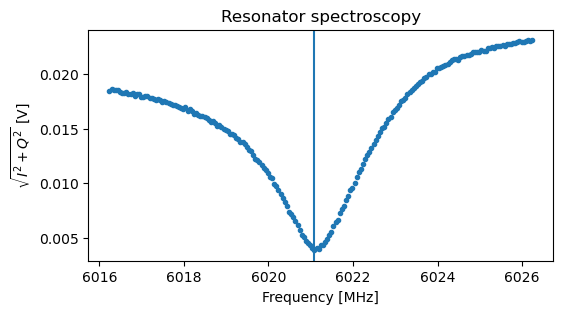

In [35]:
# calibrate RO
%matplotlib qt
#res_freq_sweep = np.arange(7.2575E9,7.2675E9 + 1.0,0.03E6)
ham_param = machine.resonators[res_index].tuning_curve
res_freq_est = Analysis.exp2D.ham([machine.flux_lines[flux_index].max_frequency_point], ham_param[0], ham_param[1], ham_param[2], ham_param[3], ham_param[4], ham_param[5], output_flag = 1) * 1E6 # to Hz
res_freq_sweep = int(res_freq_est[0]) + np.arange(-5E6, 5E6 + 1, 0.05E6)
machine, res_freq_sweep, sig_amp = Experiment.exp1D.RR.rr_freq(res_freq_sweep, qubit_index, res_index, flux_index, 
                       n_avg = 5E3, cd_time = 5E3, plot_flag = False, simulate_flag = False, simulation_len = 1000)
%matplotlib inline
res_freq = Analysis.exp1D.rr_freq(res_freq_sweep, sig_amp)
res_freq = int(res_freq.tolist())
machine.resonators[res_index].f_readout = res_freq + 0E6
machine.resonators[res_index].lo = res_freq + 50E6
machine = Analysis.set_machine(machine)

In [36]:
# calibrate octave
Experiment.octave_calibration(qubit_index,res_index,flux_index)

2024-01-04 09:41:02,898 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-01-04 09:41:02,909 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r6 for (LO, IF) = (6.071 GHz, -50.000 MHz)
2024-01-04 09:41:10,131 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q6 for (LO, IF) = (5.492 GHz, -50.000 MHz)
2024-01-04 09:41:21,846 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


In [84]:
machine.qubits[qubit_index].f_01 = machine.qubits[qubit_index].f_tls[0] + 0E6
machine.qubits[qubit_index].lo = machine.qubits[qubit_index].f_01 + 50E6
machine = Analysis.set_machine(machine)
Experiment.octave_calibration(qubit_index,res_index,flux_index,machine=machine,calibration_flag=True)

2024-01-04 13:59:36,266 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-01-04 13:59:36,274 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r6 for (LO, IF) = (6.071 GHz, -50.000 MHz)
2024-01-04 13:59:43,103 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q6 for (LO, IF) = (5.475 GHz, -50.000 MHz)
2024-01-04 13:59:55,526 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


In [85]:
if True: # for the DC flux
    qubit_freq_est = np.polyval(machine.qubits[qubit_index].DC_tuning_curve,machine.flux_lines[flux_index].max_frequency_point) * 1E6 # in Hz
else: # for the fast flux
    qubit_freq_est = np.polyval(machine.qubits[qubit_index].AC_tuning_curve,0.0) * 1E6 # in Hz
    
# After a run using the tuning curve data has been already done (uncomment top line otherwise)
# qubit_freq_sweep = int(qubit_freq_est) + np.arange(-60E6, 60E6 + 1, 1E6)
qubit_freq_sweep = int(machine.qubits[qubit_index].f_01) + np.arange(-60E6, 60E6 + 1, 1E6)

    
%matplotlib qt
machine, qubit_freq_sweep, sig_amp = Experiment.exp1D.Rabi.qubit_freq(qubit_freq_sweep, qubit_index, res_index, flux_index, 
                                      pi_amp_rel = 1.0, ff_amp = 0.0, n_avg = 1E3, cd_time = 20E3, plot_flag = False, 
                                      simulate_flag = False, simulation_len = 4000)

Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 2.50s
Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 2.54s


resonant frequency: 5425.520 MHz


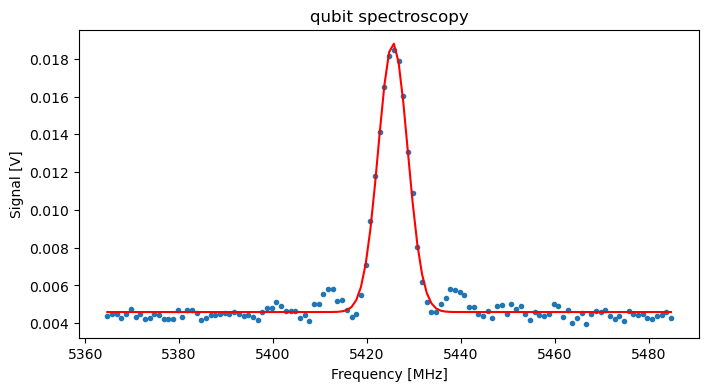

In [86]:
%matplotlib inline
qubit_freq = Analysis.exp1D.peak_fit(x=qubit_freq_sweep,y=sig_amp,method="gaussian")
qubit_freq = int(qubit_freq.tolist())
machine.qubits[qubit_index].f_01 = qubit_freq + 0E6
machine.qubits[qubit_index].f_tls[0] = qubit_freq + 0E6
machine.qubits[qubit_index].lo = qubit_freq + 50E6
machine = Analysis.set_machine(machine)

In [87]:
# calibrate octave
Experiment.octave_calibration(qubit_index,res_index,flux_index,machine=machine)

2024-01-04 14:00:16,792 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-01-04 14:00:16,802 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r6 for (LO, IF) = (6.071 GHz, -50.000 MHz)
2024-01-04 14:00:23,789 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q6 for (LO, IF) = (5.476 GHz, -50.000 MHz)
2024-01-04 14:00:36,384 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


## Rabi

### time rabi

In [52]:
%matplotlib qt
rabi_duration_sweep = np.arange(4, 100 + 0.1, 1)  # in units of clock cyles
rabi_duration_sweep = rabi_duration_sweep.astype(int)
machine, rabi_duration_sweep, sig_amp = Experiment.exp1D.Rabi.rabi_length(rabi_duration_sweep, qubit_index, res_index, flux_index, 
          pi_amp_rel = 1.0, n_avg = 2E3, cd_time = 25E3, plot_flag = False, machine = machine, simulate_flag = False, simulation_len = 10_000)

Progress: [##################################################] 100.0% (n=2000/2000.0) --> elapsed time: 5.05s
Progress: [##################################################] 100.0% (n=2000/2000.0) --> elapsed time: 5.10s


rabi_pi_pulse: 98.8 ns
half period: 97.88 ns


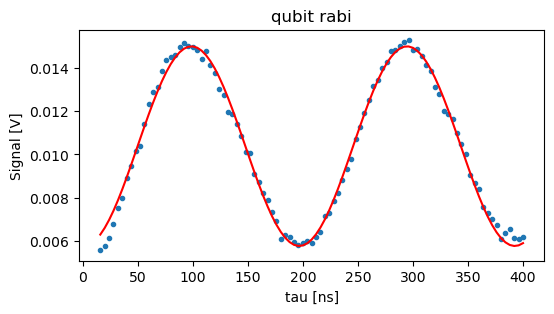

In [53]:
%matplotlib inline
pi_pulse_length = Analysis.exp1D.rabi_length(rabi_duration_sweep,sig_amp,plot_flag = True)

In [48]:
machine.qubits[qubit_index].pi_length[0] = 100
#machine.qubits[qubit_index].pi_amp[0] = 0.02
machine = Analysis.set_machine(machine)

### power rabi

In [54]:
%matplotlib qt
rabi_amp_sweep_rel = np.arange(0.3, 2.0, 0.05) 
machine, rabi_amp_sweep_abs, sig_amp = Experiment.exp1D.Rabi.rabi_amp(rabi_amp_sweep_rel, qubit_index, res_index, flux_index, 
                                          n_avg = 10E3, cd_time = 40E3, plot_flag = False, machine = machine)

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 13.79s
Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 13.84s


rabi_pi_pulse_amp: 0.01997 V
half period: 0.0193060 V


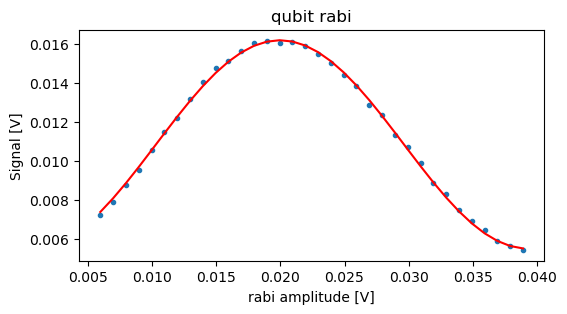

In [55]:
%matplotlib inline
pi_pulse_amp = Analysis.exp1D.rabi_length(rabi_amp_sweep_abs,sig_amp,method = "power_rabi", plot_flag = True)

In [51]:
machine.qubits[qubit_index].pi_amp[0] = pi_pulse_amp.item()
machine = Analysis.set_machine(machine)

## T1

In [56]:
%matplotlib qt
tau_sweep_abs = np.arange(100,30E3+1,500)
machine, tau_sweep_abs, sig_amp = Experiment.exp1D.T1.qubit_T1(tau_sweep_abs, qubit_index, res_index, flux_index, 
                   n_avg = 5E3, cd_time = 30E3, simulate_flag = False, simulation_len = 15_000, plot_flag = False)

Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 13.51s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 13.56s


Qubit T1 [us]: 2.65548776209659


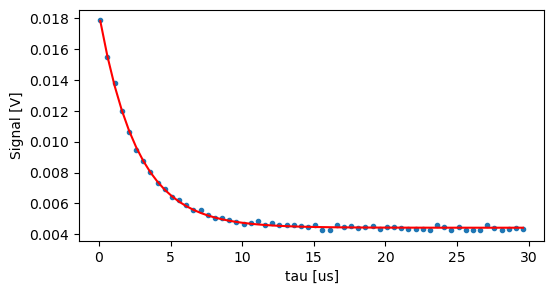

In [57]:
%matplotlib inline
q_T1 = Analysis.exp1D.T1(tau_sweep_abs,sig_amp,method = "exp")
machine.qubits[qubit_index].T1 = int(q_T1.tolist())
machine = Analysis.set_machine(machine)

## Ramsey

In [58]:
%matplotlib qt
ramsey_duration_sweep = np.arange(4, 1000 + 0.1, 5)  # in units of clock cyles
machine, ramsey_duration_sweep, sig_amp = Experiment.exp1D.Ramsey.ramsey(ramsey_duration_sweep, qubit_index, res_index, flux_index, 
          n_avg = 10E3, detuning = 2E6, cd_time = 30E3, plot_flag = True, simulate_flag = False, simulation_len = 20_000, machine = machine)

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 65.37s


Qubit T2* [ns]: 1649.7805867424509
Detuning [MHz]: 0.9931204127716626
Exponent n: 2.2074864873394713


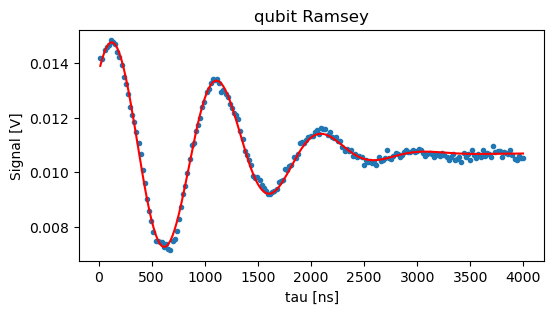

In [60]:
%matplotlib inline
q_T2star = Analysis.exp1D.ramsey(ramsey_duration_sweep, sig_amp,plot_flag = True)
machine.qubits[qubit_index].T2 = int(q_T2star.tolist())
machine = Analysis.set_machine(machine)

## ef transition

### ef frequency

In [ ]:
%matplotlib qt
ef_freq_sweep = machine.qubits[qubit_index].f_01 + np.arange(-200E6, -150E6 + 1, 0.5E6) 
machine, ef_freq_sweep, sig_amp = Experiment.exp1D.Rabi.ef_freq(ef_freq_sweep, qubit_index, res_index, flux_index, 
                      pi_amp_rel = 1, pi_amp_rel_ef = 1.0, n_avg = 2E3, cd_time = 20E3, readout_state = 'g', plot_flag = False, 
                      simulate_flag = False, simulation_len = 4000)

In [ ]:
%matplotlib inline
ef_freq = Analysis.exp1D.peak_fit(x=ef_freq_sweep,y=sig_amp,method="gaussian")

In [ ]:
machine.qubits[qubit_index].anharmonicity = machine.qubits[qubit_index].f_01 - int(ef_freq)
machine = Analysis.set_machine(machine)

### ef transition time Rabi

In [ ]:
%matplotlib qt
rabi_duration_sweep = np.arange(4, 80 + 0.1, 1)  # in units of clock cyles
rabi_duration_sweep = rabi_duration_sweep.astype(int)
machine, rabi_duration_sweep, sig_amp = Experiment.exp1D.Rabi.ef_rabi_length(rabi_duration_sweep, qubit_index, res_index, flux_index, 
          pi_amp_rel = 1.0, pi_amp_rel_ef = 1.0,  n_avg = 2E3, cd_time = 20E3, readout_state = 'g', plot_flag = False, machine = machine, simulate_flag = False, simulation_len = 10_000)

In [ ]:
%matplotlib inline
pi_pulse_length = Analysis.exp1D.rabi_length(rabi_duration_sweep,sig_amp,plot_flag = True)

In [ ]:
machine.qubits[qubit_index].pi_length[1] = 80
machine = Analysis.set_machine(machine)

### ef transition power Rabi

In [ ]:
%matplotlib qt
rabi_amp_sweep_rel = np.arange(0.2, 3.0, 0.05) 
machine, rabi_amp_sweep_abs, sig_amp = Experiment.exp1D.Rabi.ef_rabi_amp(rabi_amp_sweep_rel, qubit_index, res_index, flux_index, 
                          pi_amp_rel = 1.0, n_avg = 10E3, cd_time = 20E3, readout_state = 'g', plot_flag = False, machine = machine,
                          simulate_flag = False, simulation_len = 1000)

In [ ]:
%matplotlib inline
pi_pulse_amp = Analysis.exp1D.rabi_length(rabi_amp_sweep_abs,sig_amp,method = "power_rabi", plot_flag = True)

In [ ]:
machine.qubits[qubit_index].pi_amp[1] = pi_pulse_amp
machine = Analysis.set_machine(machine)

## 2D qubit spectroscopy vs dc flux

In [61]:
machine = Analysis.get_machine()

In [65]:
# try the experiment
%matplotlib qt
dc_flux_sweep = machine.flux_lines[flux_index].max_frequency_point + np.arange(-0.55,0.55+1E-4,0.02)
_,qubit_freq_sweep,dc_flux_sweep,sig_amp_qubit = Experiment.exp2D.Rabi.qubit_freq_vs_dc_flux(dc_flux_sweep,qubit_index,res_index,flux_index,
                                 n_avg = 2E3, cd_time = 20E3, pi_amp_rel = 1.0, plot_flag = True)

Progress: [##################################################] 100.0% (n=56/56) --> elapsed time: 1044.29s
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Ex

In [66]:
# udpate the sweet spot
%matplotlib inline
poly_param = Analysis.exp2D.qubit_vs_dc_flux(qubit_freq_sweep, dc_flux_sweep, sig_amp_qubit, fit_order = 2, plot_flag = False)
machine.flux_lines[flux_index].max_frequency_point = Analysis.get_sweept_spot(poly_param).tolist() + 0E1
print(f"sweet spot flux: {machine.flux_lines[flux_index].max_frequency_point:.5f} V")

sweet spot flux: -0.07463 V


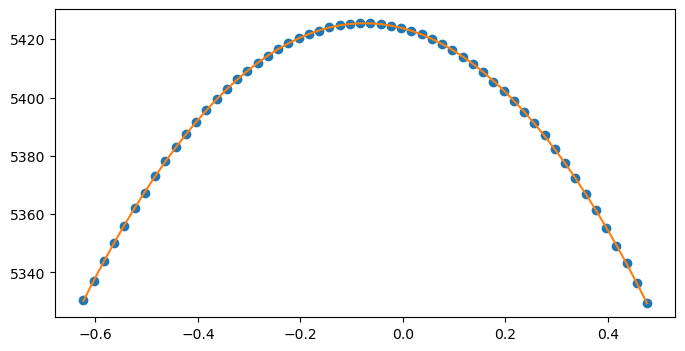

In [67]:
# save the sweep spot flux according to fitted parameter
poly_param = Analysis.exp2D.qubit_vs_dc_flux(qubit_freq_sweep, dc_flux_sweep, sig_amp_qubit, fit_order = 4, plot_flag = True)
machine.qubits[qubit_index].DC_tuning_curve = poly_param.tolist()
machine = Analysis.set_machine(machine)
Analysis.update_analysis_tuning_curve(qubit_index,res_index,flux_index)

## 2D qubit spectroscopy vs fast flux

In [68]:
# set DC voltage to sweet spot, after possible dc flux sweep
machine = Experiment.set_QDAC(qubit_index,res_index,flux_index,machine.flux_lines[flux_index].max_frequency_point)
machine = Analysis.set_machine(machine)

### slow version, compiling 1D scans

In [69]:
# octave calibration
Experiment.octave_calibration(qubit_index,res_index,flux_index,calibration_flag = False)

2024-01-04 10:32:44,700 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-01-04 10:32:44,711 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


In [74]:
# try the experiment
%matplotlib qt
#ff_sweep = np.arange(-0.02,-0.28-1E-4,-0.02)
ff_sweep = np.arange(0,0.2+1E-4,0.025)
qubit_if_sweep = np.arange(-60E6, 60E6 + 1, 1E6)
if True: # first time running this, no AC_tuning_curve
    machine,qubit_freq_sweep,ff_sweep_abs,sig_amp_qubit = Experiment.exp2D.Rabi.qubit_freq_vs_fast_flux_slow(ff_sweep,qubit_if_sweep,
          qubit_index,res_index,flux_index,ff_to_dc_ratio = 5, machine = machine, n_avg = 1E3, cd_time = 20E3, pi_amp_rel = 1.0, plot_flag = True)
else: # after the first run 
    machine,qubit_freq_sweep,ff_sweep_abs,sig_amp_qubit = Experiment.exp2D.Rabi.qubit_freq_vs_fast_flux_slow(ff_sweep,qubit_if_sweep,
          qubit_index,res_index,flux_index,ff_to_dc_ratio = None, machine = machine, n_avg = 1E3, cd_time = 20E3, pi_amp_rel = 1.0, plot_flag = True)

2024-01-04 10:37:41,292 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-01-04 10:37:41,298 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q6 for (LO, IF) = (5.136 GHz, 290.000 MHz)
2024-01-04 10:37:45,958 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


2024-01-04 10:38:33,384 - qm - INFO     - Performing health check.8% (n=7/9) --> elapsed time: 52.06s


INFO:qm.api.frontend_api:Performing health check


2024-01-04 10:38:33,394 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q6 for (LO, IF) = (4.955 GHz, 290.000 MHz)
2024-01-04 10:38:38,436 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


Progress: [##################################################] 100.0% (n=9/9) --> elapsed time: 83.22s
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!


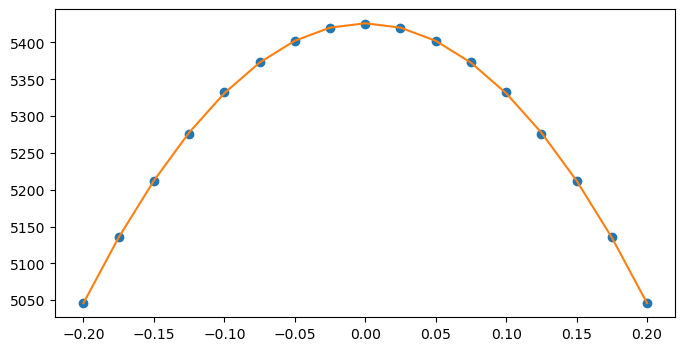

In [75]:
# save the fitted tuning curve
%matplotlib inline
poly_param = Analysis.exp2D.qubit_vs_fast_flux(qubit_freq_sweep, ff_sweep_abs, sig_amp_qubit, fit_order = 4, plot_flag = True)
machine.qubits[qubit_index].AC_tuning_curve = poly_param.tolist()
machine = Analysis.set_machine(machine)
Analysis.update_analysis_tuning_curve(qubit_index,res_index,flux_index)

### fast version, runs blockwise 2D sweeps

In [76]:
machine = Analysis.get_machine()

In [90]:
%matplotlib qt
fig = plt.figure()
plt.rcParams['figure.figsize'] = [8, 4]
plt.pcolormesh(qubit_freq_sweep / u.MHz, ff_sweep_abs, sig_amp_qubit, cmap="seismic")
plt.title("Qubit tuning curve")
plt.xlabel("fast flux level [V]")
plt.ylabel("Frequency [MHz]")
plt.colorbar()

TypeError: Dimensions of C (386, 201) should be one smaller than X(121) and Y(321) while using shading='flat' see help(pcolormesh)

In [82]:
%matplotlib qt
q_freq_max = np.floor(np.polyval(machine.qubits[qubit_index].AC_tuning_curve, 0.0) * 1E6)
qubit_freq_sweep = np.arange(q_freq_max, 3.5E9, -5E6)
#qubit_freq_sweep = np.arange(q_freq_max,4E9,-100E6)
qubit_if_sweep = np.arange(-50E6, 50E6 + 1, 0.5E6)
machine,qubit_freq_sweep,ff_sweep_abs,sig_amp_qubit = Experiment.exp2D.Rabi.qubit_freq_vs_fast_flux(qubit_freq_sweep,qubit_if_sweep,
          qubit_index,res_index,flux_index, n_avg = 5E3, cd_time = 25E3, plot_flag = True)

2024-01-04 10:58:20,059 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-01-04 10:58:20,067 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q6 for (LO, IF) = (5.127 GHz, 200.000 MHz)
2024-01-04 10:58:24,849 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1048.38s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1048.54s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1048.38s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1048.53s
2024-01-04 11:33:42,199 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-01-04 11:33:42,213 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q6 for (LO, IF) = (4.927 GHz, 200.000 MHz)
2024-01-04 11:33:47,436 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1048.38s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1048.53s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1048.44s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1048.59s
2024-01-04 12:09:06,948 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-01-04 12:09:06,960 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q6 for (LO, IF) = (4.327 GHz, 200.000 MHz)
2024-01-04 12:09:12,129 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1048.38s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1048.54s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1048.31s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1048.46s
2024-01-04 12:44:29,334 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-01-04 12:44:29,349 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q6 for (LO, IF) = (4.127 GHz, 200.000 MHz)
2024-01-04 12:44:34,152 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1048.30s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1048.45s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1048.24s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1048.40s
2024-01-04 13:19:51,916 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-01-04 13:19:51,929 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q6 for (LO, IF) = (3.527 GHz, 200.000 MHz)
2024-01-04 13:19:56,652 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1048.45s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 1048.59s
2024-01-04 13:37:42,658 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-01-04 13:37:42,672 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates q6 for (LO, IF) = (3.327 GHz, 200.000 MHz)
2024-01-04 13:37:47,810 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 681.38s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 681.53s


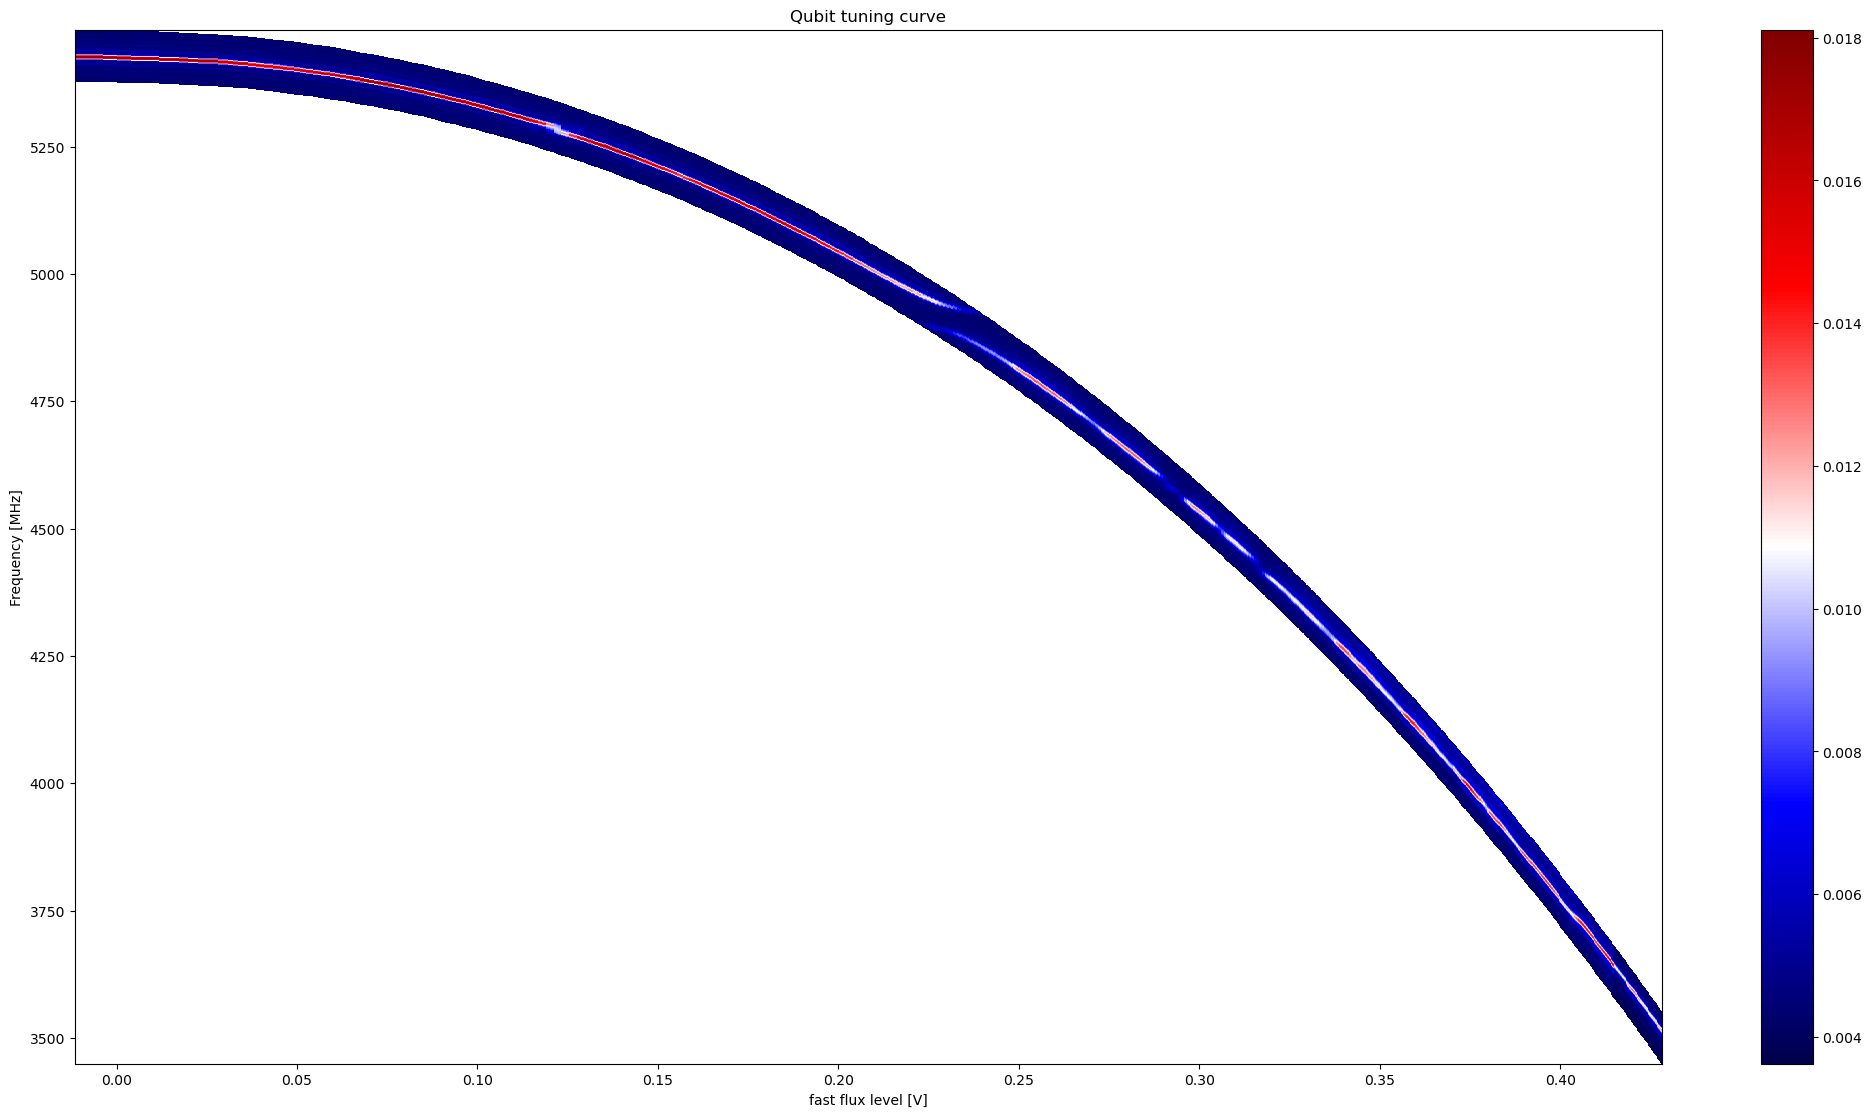

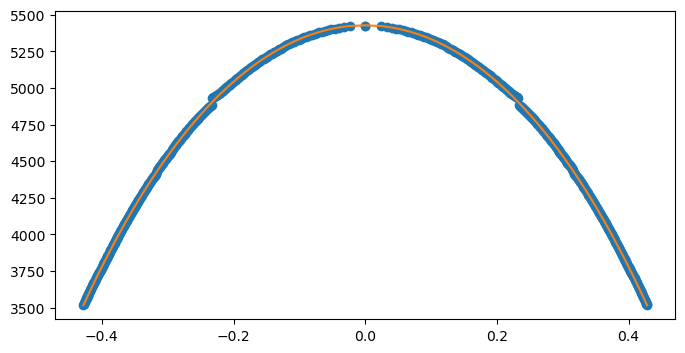

Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!
Execution stopped by user!


In [83]:
# save the fitted tuning curve
%matplotlib inline
poly_param = Analysis.exp2D.qubit_vs_fast_flux(qubit_freq_sweep, ff_sweep_abs, sig_amp_qubit, fit_order = 4, plot_flag = True)
machine.qubits[qubit_index].AC_tuning_curve = poly_param.tolist()
#machine.qubits[qubit_index].AC_tuning_curve = [-4245.549395948013,0.0,-6707.594982241495,0.0,6413.009439410573]
machine = Analysis.set_machine(machine)
Analysis.update_analysis_tuning_curve(qubit_index,res_index,flux_index)

# TLS experiments

## TLS SWAP spectroscopy

In [ ]:
machine = Analysis.get_machine()
Experiment.octave_calibration(qubit_index,res_index,flux_index,calibration_flag = True, machine = machine)

### coarse, no baking

In [107]:
%matplotlib qt
tau_sweep_abs = np.arange(16,160 + 0.1,4)
ff_sweep_abs = np.arange(0.25,0.35,0.002)
machine, ff_sweep_abs, tau_sweep_abs, sig_amp = Experiment.exp2D.SWAP.swap_coarse(tau_sweep_abs, ff_sweep_abs, qubit_index, res_index, flux_index, 
                      n_avg = 1E3, cd_time = 20E3, simulate_flag=False, simulation_len=10_000, plot_flag=True, machine = machine)

Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 38.85s
Execution stopped by user!


### fine, with baking

In [89]:
%matplotlib qt
tau_sweep_abs = np.arange(4,100,1)
ff_sweep_abs = np.arange(0.19,0.35+1E-4,0.0005)
machine, ff_sweep_abs, tau_sweep_abs, sig_amp = Experiment.exp2D.SWAP.swap_fine(tau_sweep_abs, ff_sweep_abs, qubit_index, res_index, flux_index, 
                      n_avg = 5E3, cd_time = 25E3, simulate_flag=False, simulation_len=10_000, plot_flag=True, machine = machine)

Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 7811.66s
Progress: [##################################################] 100.0% (n=5000/5000.0) --> elapsed time: 7811.82s


In [91]:
machine.flux_lines[flux_index].iswap.length = [22]
machine.flux_lines[flux_index].iswap.level = [0.231]
machine = Analysis.set_machine(machine)

### estiguess of the TLS freq., based on SWAP flux

In [92]:
machine = Analysis.get_machine()

In [93]:
freq_tls = np.polyval(machine.qubits[qubit_index].AC_tuning_curve,machine.flux_lines[flux_index].iswap.level)
for f_tmp in freq_tls:
    machine.qubits[qubit_index].f_tls.append(np.floor(f_tmp*1E6))
machine = Analysis.set_machine(machine)

## TLS T1

In [94]:
print(freq_tls)

[4909.89240902]


In [108]:
TLS_index = 0

In [109]:
%matplotlib qt
tau_sweep_abs = np.arange(100,2000E3+1,10E4)
# tau_sweep_abs = np.logspace(100,2000E3,50,endpoint=True)
machine, tau_sweep_abs, sig_amp = Experiment.exp1D.T1.TLS_T1(tau_sweep_abs, qubit_index, res_index, flux_index, TLS_index,
                   n_avg = 4E3, cd_time_qubit = 25E3, cd_time_TLS = 2200E3, simulate_flag = False, simulation_len = 15_000, plot_flag = True)

Execution stopped by user!                                   ] 27.5% (n=1098/4000.0) --> elapsed time: 70.11s


Qubit T1 [us]: 314.20303652726034


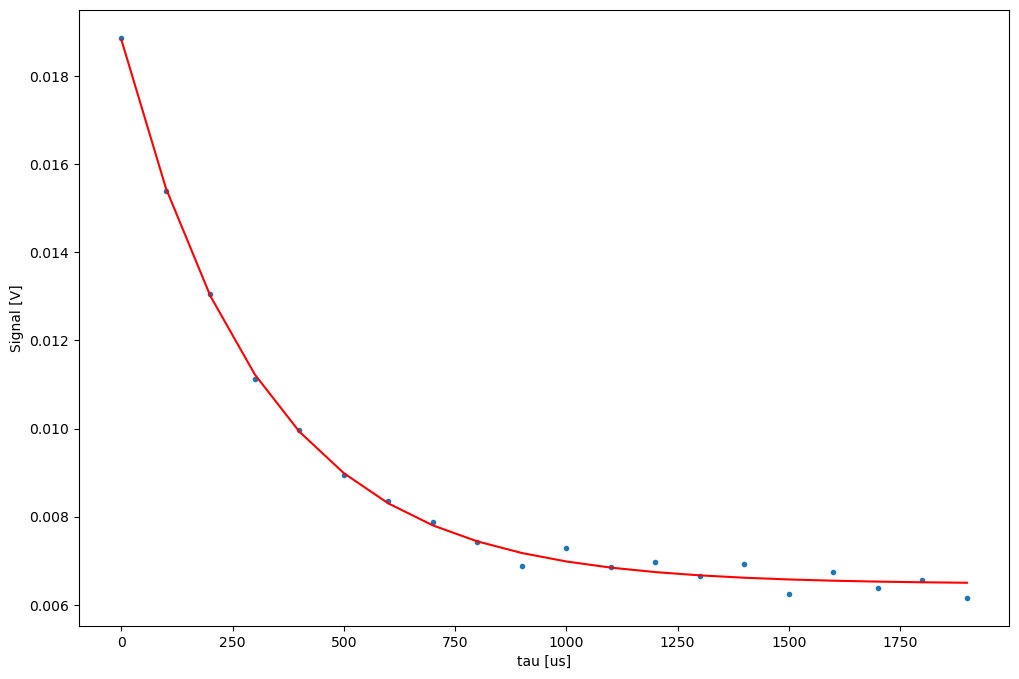

In [110]:
%matplotlib inline
TLS_T1 = Analysis.exp1D.T1(tau_sweep_abs,sig_amp,method = "exp")

## TLS drive

### TLS spectroscopy

In [ ]:
TLS_index = 0

In [135]:
# TLS freq estimate based on SWAP flux amplitude
TLS_freq_est = np.polyval(machine.qubits[qubit_index].AC_tuning_curve,machine.flux_lines[flux_index].iswap.level[TLS_index])
TLS_freq_est = np.round(TLS_freq_est * 1E6)
machine.qubits[qubit_index].f_tls[TLS_index+1] = (int(TLS_freq_est.tolist()))
machine.qubits[qubit_index].lo = int(TLS_freq_est.tolist()) - 250E6

In [136]:
# set the "qubit frequency"
machine.qubits[qubit_index].f_01 = machine.qubits[qubit_index].f_tls[TLS_index+1] + 0E6
machine = Analysis.set_machine(machine)

In [146]:
# calibrate octave for TLS sweep
Experiment.octave_calibration(qubit_index,res_index,flux_index,machine = machine,calibration_flag = True)

2024-01-05 11:18:21,869 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-01-05 11:18:21,878 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r6 for (LO, IF) = (6.071 GHz, -50.000 MHz)
2024-01-05 11:18:29,415 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q6 for (LO, IF) = (4.664 GHz, 250.000 MHz)
2024-01-05 11:18:41,388 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


In [140]:
%matplotlib qt
TLS_freq_sweep = TLS_freq_est + np.arange(-20E6,20E6+1,1.0E6)
machine, TLS_freq_sweep, sig_amp = Experiment.exp1D.Rabi.TLS_freq(TLS_freq_sweep, qubit_index, res_index, flux_index, TLS_index,
                  pi_amp_rel = 1.0, n_avg = 2E3, cd_time_qubit = 20E3, cd_time_TLS = 20E3, simulate_flag = False, simulation_len = 10_000, plot_flag = True, machine = machine)

Progress: [##################################################] 100.0% (n=2000/2000.0) --> elapsed time: 3.28s
Progress: [##################################################] 100.0% (n=2000/2000.0) --> elapsed time: 3.37s
Execution stopped by user!


In [143]:
%matplotlib qt
qubit_freq = Analysis.exp1D.peak_fit(x=TLS_freq_sweep,y=sig_amp,method="gaussian")
qubit_freq = int(qubit_freq.tolist())
machine.qubits[qubit_index].f_tls[TLS_index+1] = qubit_freq + 0E6
machine.qubits[qubit_index].lo = qubit_freq - 250E6
machine = Analysis.set_machine(machine)

resonant frequency: 4913.672 MHz


### TLS rabi

In [144]:
# # save the current qubit to the f_tls[0]
# machine.qubits[qubit_index].f_tls[0] = machine.qubits[qubit_index].f_01
# set the "qubit frequency"
machine.qubits[qubit_index].f_01 = machine.qubits[qubit_index].f_tls[TLS_index+1] +0E6

In [145]:
# calibrate octave 
Experiment.octave_calibration(qubit_index,res_index,flux_index,machine = machine,calibration_flag = True)

4913671852.0

In [154]:
%matplotlib qt
rabi_duration_sweep = np.arange(4, 300 + 0.1, 4)  # in units of clock cyles
machine, rabi_duration_sweep, sig_amp = Experiment.exp1D.Rabi.TLS_rabi_length(rabi_duration_sweep, qubit_index, res_index, flux_index, TLS_index,
                  pi_amp_rel = 1.0, n_avg = 10E3, cd_time_qubit = 20E3, cd_time_TLS = 20E3, simulate_flag = False, simulation_len = 10_000, plot_flag = True, machine = machine)

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 30.65s
Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 30.74s
Execution stopped by user!
